In [95]:
import numpy as np
import chess

def fen_to_board(fen):
    # Parse the FEN string
    parts = fen.split(" ")
    board_part = parts[0]
    isWhite = parts[1] == 'w'

    # Initialize the binary board
    binary_board = np.zeros((768,), dtype=np.float32)
    pieces = {'p': 0, 'r': 1, 'n': 2, 'b': 3, 'q': 4, 'k': 5,
              'P': 6, 'R': 7, 'N': 8, 'B': 9, 'Q': 10, 'K': 11}
    
    # Parse the board part of the FEN string
    rows = board_part.split('/')
    for i, row in enumerate(rows):
        col = 0
        for char in row:
            if char.isdigit():
                # Empty squares
                col += int(char)
            else:
                # Piece
                if isWhite:
                    binary_board[(i*8 + col)*12 + pieces[char]] = 1
                else:
                    binary_board[(63-(i*8 + col))*12 + (pieces[char]+6)%12] = 1
                col += 1

    return binary_board


In [96]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim


class SquaredClippedReLU(nn.Module):
    def forward(self, input):
        return F.relu(input.clamp(max=1))**2

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(768, 768)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(768, 1)

    def forward(self, x):
        x = SquaredClippedReLU()(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = Net()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [97]:
print(model)

Net(
  (fc1): Linear(in_features=768, out_features=768, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=768, out_features=1, bias=True)
)


In [98]:
import random
# with open(r'akimbo-2085723380.epd', 'r') as f:
with open(r'fen_ratingsomate2.txt', 'r') as f:
    lines = f.readlines()
    
random.shuffle(lines)
fens = [line.split()[0] + " " + line.split()[1] + " " + line.split()[2] for line in lines]
ratings = [-float(line.split()[-1]) if line.split()[1] == 'b' else float(line.split()[-1]) for line in lines] 

binary_boards = []

for fen in fens:
    binary_board = fen_to_board(fen)
    binary_boards.append(binary_board)

binary_boards = np.array(binary_boards)
ratings = np.array(ratings)


In [99]:
train_size = int(len(binary_boards) * 0.7)
val_size = int(len(binary_boards) * 0.15)

# Separate binary boards and piece amounts
x_binary_train, y_train = binary_boards[:train_size], ratings[:train_size]
x_binary_val, y_val = binary_boards[train_size:train_size + val_size], ratings[train_size:train_size + val_size]
x_binary_test, y_test = binary_boards[train_size + val_size:], ratings[train_size + val_size:]


In [100]:
# Convert your data to PyTorch tensors
x_binary_train_tensor = torch.tensor(x_binary_train).float()
y_train_tensor = torch.tensor(y_train).float()

x_binary_val_tensor = torch.tensor(x_binary_val).float()
y_val_tensor = torch.tensor(y_val).float()

x_binary_test_tensor = torch.tensor(x_binary_test).float()
y_test_tensor = torch.tensor(y_test).float()


# Ensure your model parameters are of the same data type
model = model.float()


# Create a dataset from your data
train_dataset = TensorDataset(x_binary_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_binary_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_binary_test_tensor, y_test_tensor)

# Create a DataLoader with batch size
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [101]:
from tqdm import tqdm

lambda_l2 = 0.01
train_losses = []
val_losses = []
train_mae = []
val_mae = []

for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    running_mae = 0.0
    model.train()  # Set the model to training mode
    progress_bar = tqdm(enumerate(train_dataloader, 0), total=len(train_dataloader))
    for i, data in progress_bar:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # L2 regularization
        # l2_reg = torch.tensor(0.).to(inputs.device)
        # for param in model.parameters():
        #     l2_reg += torch.norm(param)
        # loss += lambda_l2 * l2_reg

        loss.backward()
        optimizer.step()

        # calculate MAE
        mae = torch.abs(outputs - labels).mean()

        # print statistics
        running_loss += loss.item()
        running_mae += mae.item()
        progress_bar.set_description(f"Epoch {epoch+1} Loss: {running_loss/(i+1):.4f} MAE: {running_mae/(i+1):.4f}")
    train_losses.append(running_loss / len(train_dataloader))
    train_mae.append(running_mae / len(train_dataloader))

    # Validation phase
    running_loss = 0.0
    running_mae = 0.0
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to track gradients in validation phase
        for i, data in enumerate(val_dataloader, 0):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            mae = torch.abs(outputs - labels).mean()
            running_loss += loss.item()
            running_mae += mae.item()
    val_losses.append(running_loss / len(val_dataloader))
    val_mae.append(running_mae / len(val_dataloader))
    print(f"Validation Loss at Epoch {epoch+1}: {running_loss/len(val_dataloader):.4f} MAE: {running_mae/len(val_dataloader):.4f}")


  0%|          | 0/111571 [00:00<?, ?it/s]c:\Users\21thebes\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1 Loss: 0.0001 MAE: 0.0048:   7%|▋         | 8061/111571 [00:56<12:00, 143.57it/s]


KeyboardInterrupt: 

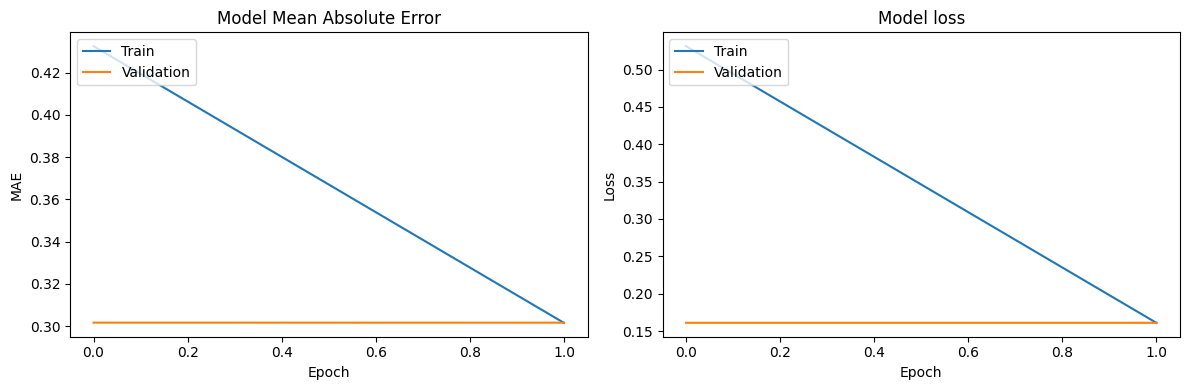

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation MAE values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_mae)  
plt.plot(val_mae) 
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
torch.save(model.state_dict(), 'TrainedModel.pt')


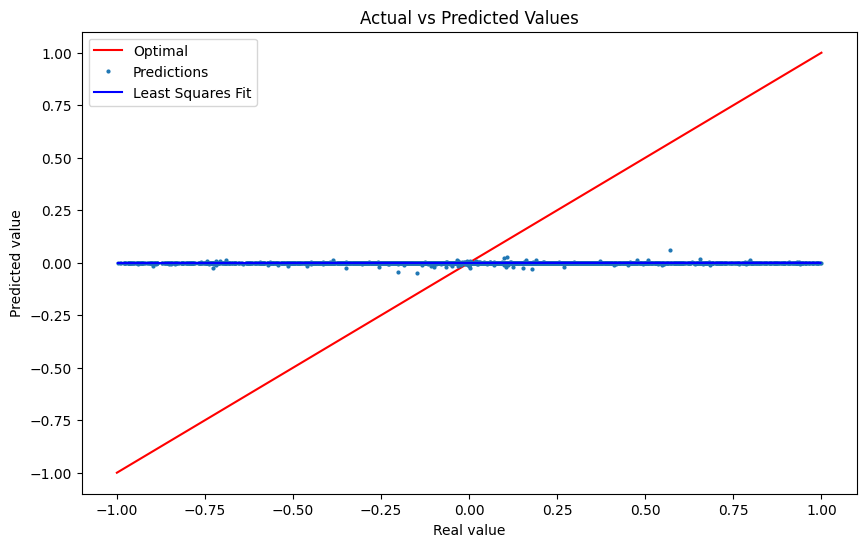

Predicted rating: [-0.00102538], True rating: -0.161
Predicted rating: [-0.00102538], True rating: -0.484
Predicted rating: [-0.00102538], True rating: -0.091
Predicted rating: [-0.00102538], True rating: -0.388
Predicted rating: [-0.00102538], True rating: -0.043
Predicted rating: [-0.00102538], True rating: -0.001
Predicted rating: [-0.00102538], True rating: -0.622
Predicted rating: [-0.00102538], True rating: 0.128
Predicted rating: [-0.00102538], True rating: 0.391
Predicted rating: [-0.00102538], True rating: 0.159
Predicted rating: [-0.00102538], True rating: 0.014
Predicted rating: [-0.00102538], True rating: 0.45
Predicted rating: [-0.00102538], True rating: 0.036
Predicted rating: [-0.00317745], True rating: 0.0
Predicted rating: [-0.00102538], True rating: -0.073
Predicted rating: [-0.01240993], True rating: 0.1
Predicted rating: [-0.00102538], True rating: -0.125
Predicted rating: [-0.00116594], True rating: -0.309
Predicted rating: [-0.00102538], True rating: -0.706
Predic

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x_test_tensor = torch.tensor(x_binary_test[:3000]).float()

# Predict the ratings for the test data
model.eval()
with torch.no_grad():
    y_pred = model(x_test_tensor)

# Convert the predictions to a numpy array
y_pred = y_pred.numpy()

plt.figure(figsize=(10, 6))

# Line x=y for perfect predictions
plt.plot([-1, 1], [-1, 1], color='red', label='Optimal')

# Scatter plot of actual vs predicted values
plt.plot(y_test[:3000], y_pred, marker='o', linestyle='None', markersize=2.0, label='Predictions')

# Least squares fit line
coeff = np.polyfit(y_test[:3000].flatten(), y_pred.flatten(), 1)
fit_line = np.polyval(coeff, y_test[:3000].flatten())
plt.plot(y_test[:3000], fit_line, color='blue', label='Least Squares Fit')

plt.title('Actual vs Predicted Values')
plt.xlabel('Real value')
plt.ylabel('Predicted value')
plt.legend()

plt.show()

# Print the predicted and true ratings for the test data
for i in range(min(len(y_test), 300)):
    print(f"Predicted rating: {y_pred[i]}, True rating: {y_test[i]}")
